# Tutorial: Evaluating Policies & First Contact with State of the Art Continuous RL methods

This is a hands-on tutorial to get familiar with the following topics:

 - OpenAI ```gym``` 2D "videogame" environments
 - State-of-the-art methods for RL over continuous control spaces
 - Measuring the performance of a given policy and reporting it

We will rely heavily on four scientific Python computing frameworks:

 - Numpy & Scipy - we will use for high performance algebraic computation and statistical analysis
 - Pandas - very useful framework to analyze and manage complex datasets
 - Matplotlib - essential for visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Bipedal Walker

Bipedal Walker is a straightforward task that can be decomposed into two subtasks. One is to keep the robot upright, as it lacks the means to pull itself back on its feet. The second is to move as fast as possible towards the right, as reward grows linearly with the distance from the origin. The first subtask needs to be achieved indifinetly and concurrently with the second one. 

Besides the challenge posed by the robot dynamics, 4(?) degrees of freedom, plus modeling of inertia, the ground is uneven. These "bumps" along the way complicate keeping balance while moving fast, as if the robot goes too fast it can be impossible to stabilize.

A further interestin feature of this environment is that there are several "tracks" with bumps distributed in different ways. **Note**: at the moment of writing this I haven't yet worked out if the bumps are generated procedurally, that is, depend on the initialization of the RNG or they are selected from a given set.

In [2]:
import gym

In [3]:
env = gym.make('BipedalWalker-v2')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


## Baseline Policies

The very first step in experimental design is to identify _baseline_ approaches. That is, already existing algorithms etc. that we can compare our stuff with. We will work with two type of baselines: those which are "competitive" and those which aren't but illustrate some important aspect of the problem.

Competitive baselines are essentially algorithms we will be expecting to be difficult to improve on the environments and initial states they have been reported. Non-competitive, _proof of concept_ baselines are not meant to do _better_ than our method. In the case they do, then it is likely that we have identified a conceptual flaw or a bug in the implementation of our algorithms.

### Random Policy

Random policies are interesting to us as a proof of concept baseline because most RL methods, at the earlier stages of training, behave pretty much "randomly". I use double quotes because this "randomness" is actually determined  by how well or badly the algorithm does _exploration_ to identify policies that lead to rewarding transitions, and how flexible it is to switch to _exploitation_ (and back) to reduce the variance in the returns of the incumbent policy.

Therefore, we will expect our algorithms (and that of others) to start close or perhaps worse than the random policy, and become more efficient as the number of transitions observed and episodes increases.

In [4]:
num_trials = 1000
trials_per_checkpoint = 10
checkpoints = []
random_observed_R = []

for trial in range(10, num_trials+1, trials_per_checkpoint):
    R = 0
    env.reset()
    for t in range(100):
        # the following call implements a random policy that picks actions from a uniform distribution
        u_t = env.action_space.sample()
        next, r, done, info = env.step(u_t)
        R += r
        if done: break
    checkpoints.append(trial)
    random_observed_R.append(R)
checkpoints = np.array(checkpoints)
random_observed_R = np.array(random_observed_R)

In the code above we're taking $100$ samples on the performance of the random policy. Note that the random policy doesn't change over time, and each trial should be independent of the previous one, unless the environment is buggy and the ```reset()``` method isn't implemented correctly.

### Zero Input

A _zero input_ policy is the simplest one: do nothing at all. This policy is in informative tasks that require to keep the system being control in or near a target state for as long as possible. When the dynamics are subject to random perturbation and the starting state is close or already inside this target region, this policy may be optimal or a very good one.

In [5]:
num_trials = 1000
trials_per_checkpoint = 10
zero_observed_R = []

for trial in range(10, num_trials+1, trials_per_checkpoint):
    R = 0
    env.reset()
    for t in range(100):
        u_t = np.zeros(env.action_space.shape)
        next, r, done, info = env.step(u_t)
        R += r
        if done: break
    zero_observed_R.append(R)

zero_observed_R = np.array(zero_observed_R)

### Comparing Policies Robustly

In order to compare policies _robustly_ it is necessary to take a **significant** number of samples of their behaviour on a simulator and also display **clearly** expected rewards change over time.

In the case of the two baselines above, and of any policy which doesn't use feedback to adjust their internal structure and/or parameters, expected rewards are _stationary_ distributions. The reason why I choose to display them in the fashion below is that we will be typically want to compare visually how the performance of policies change over time, as they collect more feedback by interacting with a simulator or environment.

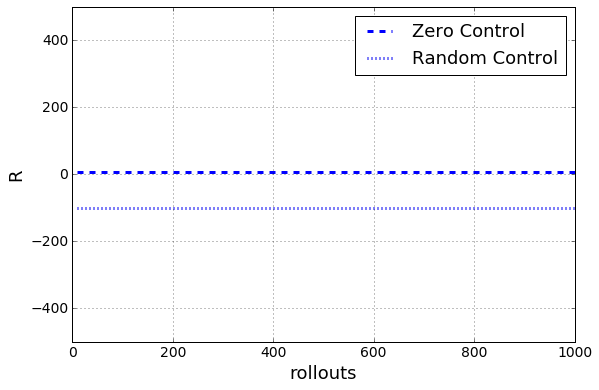

In [6]:
colors = [ '#2D328F', '#F15C19',"#81b13c","#ca49ac"]
          
label_fontsize = 18
tick_fontsize = 14
linewidth = 3
markersize = 5

median_zero = np.median(zero_observed_R)
plt.plot([checkpoints[0],checkpoints[-1]], [median_zero, median_zero], color='#0000FF', linewidth=linewidth,\
             linestyle='--',label='Zero Control')
median_random = np.median(random_observed_R)
plt.plot([checkpoints[0],checkpoints[-1]], [median_random, median_random], color='#0000F3', linewidth=linewidth,\
             linestyle=':', label='Random Control')

plt.axis([0,1000,-500,500])

plt.xlabel('rollouts',fontsize=label_fontsize)
plt.ylabel('R',fontsize=label_fontsize)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 1.0))
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()

## State of the Art RL over Continuous Control Spaces

The first continuous RL algorithm I suggest to use in our experiments is _Augmented Random Search_ (ARS), which has been recently shown to outperform quite clearly more traditional RL algorithms. The full description of ARS and a discussion of the significance of the experimental results can be found on this paper:


> **Simple random search provides a competitive approach to reinforcement learning**

> Horia Mania, Aurelia Guy, Benjamin Recht

>[arxiv.org](https://arxiv.org/abs/1803.07055) | [PDF](https://arxiv.org/pdf/1803.07055)

Briefly and informally, rather than seeking the optimal parameters $\theta^*$ of the policy via stochastic gradient descent, or more robust variants looking at the dual of the optimization problem like Trust Region Policy Optimisaton (TRPO) methods, ARS doesn't need to compute the derivatives of the parameters. Rather, it estimates the gradient directly via _finite differences_, searching over the space of parameters $\theta$ following a random search strategy. 

ARS is an iterative optimisation algorithm that proceeds as follows. First, a number of random direction vectors defined in $\theta$-space is selected. Second, the point in parameters space corresponding to the incumbent policy parameters is projected along each of these vectors. Then, each of the resulting points is slightly perturbed with additive Gaussian noise, resulting in a number of _evaluation_ policies, $\delta$. Each of these policies is then evaluated via Monte Carlo rollouts. The rewards associated to each $\delta$ then define the contribution each of these $\delta$ policies makes to the parameters of the updated policy.

Evolutionary (genetic) algorithms essentially are closely related to ARS, proposing specific heuristics to define how to sample directions and evaluation policies $\delta$.

### Implementation

I have been working for some time with ARS and I have adapted the code they released to make it more useable (at least for me). You can find the fork [on this repo](https://github.com/miquelramirez/ARS). 

I do not recommend that you install it in your system, as we will be probably modifying the code quite often over the next few months. But you can do as you please, there's a fully functional ```setup.py``` script that you can use to install the modules.

The dependencies you need to have installed are listed in the ```setup.py``` script. If there's any missing, feel free to let me know via an issue on the Github repo.

### Running ARS

The commands to use ARS to solve the ```BipedalWalker-v2``` environment are described below. They need to be issued from within the folder where you cloned the repo, or wherever if you installed the package.

State of the art RL methods rely heavily on distributed computation, and ARS is no exception. To parallelise the rollouts of the $\delta$ policies, ARS uses [ray](https://github.com/ray-project/ray). So the first thing we need to do is to initialise the ```ray``` service in our localhost (or the cluster)

```
$ ray start --head --redis-port=6379 --num-workers=6
```

The ```redis-port``` argument allows you to customise the port on which the ```ray``` server will be listening for connections from the processes spawned by ARS. I would suggest not to change it, as ```ray``` is not very robust when you start changing default configurations. The parameter ```num-workers``` allows you to specify how worker processes will you allow on the computation node in a HPC cluster, laptop or desktop. In the example I used ```6``` because my machine at home has 8 logical processors.

If ray was properly installed, you should be prompted with a connection address, that in my machine at work came out to be

```
10.100.228.201:6379
```

and probably will be something different (or localhost) for you.

We can start the fun with the following command

```
$ python -m ars --env_name gym:BipedalWalker-v2 --n_directions 240 --deltas_used 240 --step_size 0.02 \ 
--delta_std 0.0075 --n_workers 6 --n_iter 1000 --address 10.100.228.201:6379
```

where the arguments specify:

 - ```env_name``` - a string that contains the name of the module and the environment to work with separated with a colon ":"
 - ```n_directions``` - number of directions ARS is going to be exploring
 - ```n_deltas``` - number of $\delta$ policies generated at each of the projected points
 - ```step_size``` - $\alpha$ used by the finite-difference method that combines the $\delta$ policies
 - ```delta_std``` - amplitude of the Gaussian noise used to generate the $\delta$ policies
 - ```n_workers``` - number of worker threads to be create to for rolling out $\delta$ policies, it needs to be less than or equal than the number of workers available in the node
 - ```n_iter``` - number of training episodes
 - ```address``` - the address returned by the ```ray``` server upon initializaion

When the above terminates, and it will take a while, you can evaluate and visualize the behaviour obtained by simulated the resulting policy with the following command

```
$ python3 -m ars.run_policy data/lin_policy_plus.npz BipedalWalker-v2 --render --num_rollouts 20
```

where ```num_rollouts``` is the number of simulations to be conducted.

### Loading pre-trained policy

In my rig, training the policy took over $20,000$ seconds, so YMMV. I have provided two policies at different stages of training with the notebook. The one I will be using for the discussion that follows is inside this folder

In [7]:
DATA_DIR = "./trained_policies/BipedalWalker-v1/e_1000"

Loading the (linear) policy obtained by ARS as well as the state filter (see the ARS paper for more details) is quite straightforward

In [8]:
import os

print('loading policy...')
lin_policy = np.load(os.path.join(DATA_DIR, "lin_policy_plus.npz"))
lin_policy = list(lin_policy.items())[0][1]

M = lin_policy[0]
# mean and std of state vectors estimated online by ARS.
mean = lin_policy[1]
std = lin_policy[2]

loading policy...


Now we can evaluate this policy very much like we have done with the baseline policies (the cell below will take a while to complete)

In [10]:
env = gym.make('BipedalWalker-v2')

returns = []
observations = []
actions = []
for i in range(num_trials):
    #print('iter', i)
    obs = env.reset()
    done = False
    totalr = 0.
    steps = 0
    while not done:
        action = np.dot(M, (obs - mean)/std)
        observations.append(obs)
        actions.append(action)


        obs, r, done, _ = env.step(action)
        totalr += r
        steps += 1
        if steps >= env.spec.timestep_limit:
            break
    returns.append(totalr)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Once we got our data, we follow the same conventions (changing colours and line style for clarity)

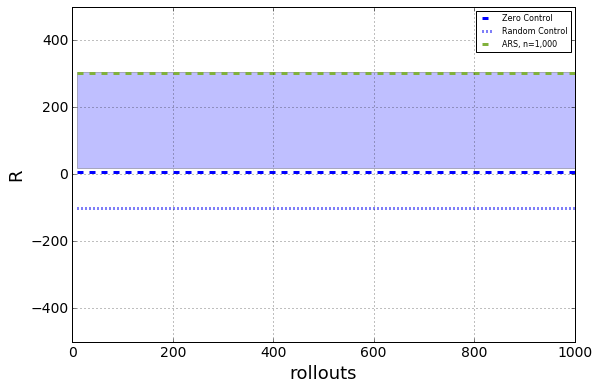

In [11]:
colors = [ '#2D328F', '#F15C19',"#81b13c","#ca49ac"]
          
label_fontsize = 18
tick_fontsize = 14
linewidth = 3
markersize = 5

median_zero = np.median(zero_observed_R)
plt.plot([checkpoints[0],checkpoints[-1]], [median_zero, median_zero], color='#0000FF', linewidth=linewidth,\
             linestyle='--',label='Zero Control')

median_random = np.median(random_observed_R)
plt.plot([checkpoints[0],checkpoints[-1]], [median_random, median_random], color='#0000F3', linewidth=linewidth,\
             linestyle=':', label='Random Control')

plt.plot(checkpoints, np.ones(checkpoints.shape)*np.median(returns, axis=0), \
         '--', color=colors[2], linewidth=linewidth, markersize=markersize,label='ARS, n=1,000')
plt.fill_between(checkpoints, np.ones(checkpoints.shape)*np.min(returns, axis=0), \
                 np.ones(checkpoints.shape)*np.max(returns, axis=0), alpha=0.25)

plt.axis([0,1000,-500,500])

plt.xlabel('rollouts',fontsize=label_fontsize)
plt.ylabel('R',fontsize=label_fontsize)
plt.legend(fontsize=8, bbox_to_anchor=(1.0, 1.0))
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()

From the plot above it is apparent that the policy obtained by ARS is neatly superior to both baselines. Yet as the shaded area belies, which roughly represents the variance in the reward of the policy, sometimes we get very unlucky.

### We never stop learning

A major formal issue with Reinforcement Learning algorithms is that we are never sure when they have converged to an optimal solution. In effect, there's good reason to assume that any autonomous systems relying on the current generation of algorithms will be pretty much learning during the whole of their useful operational life.

So, if we can't know whether we have "solved" the problem and found the optimal solution, what can we say about the robustness our RL systems. In terms of strong guarantees very little, but still we can compare the temporal evolution of expected rewards as training progresses with our chosen baselines.

To do so, we will load with ```pandas``` the experiment log generated by the ```ars``` module, that captures key measurements on the training process

In [12]:
training_obs = pd.read_csv(os.path.join(DATA_DIR, "log.txt"), delimiter='\t')

we can take a look at the structure of the dataset with the ```head()``` method that show us the header of the dataset and the few first rows

In [13]:
training_obs.head()

,Time,Iteration,AverageReward,StdRewards,MaxRewardRollout,MinRewardRollout,timesteps
0,162.278378,10,-5.393760,0.363248,-5.246280,-6.731652,3180908
1,387.659025,20,-1.460207,0.121865,-0.747162,-1.843203,7970813
2,612.988222,30,-1.791105,0.067068,-1.649446,-1.879364,12748985
3,833.122233,40,-1.559103,0.065430,-1.432477,-1.946071,17527134
4,1054.298722,50,-2.456541,0.624083,-1.047739,-3.197368,22320077


```ARS``` has been collecting every ten training episodes useful information such as:

 - ```Time``` - the total elapsed CPU time since the training process started
 - ```Iteration``` - the index of the episode measured
 - ```AverageReward``` - average reward of the policies since the last "checkpoint"
 - ```StdRewards``` - standard deviation of the rewards achieved
 - ```MaxRewardRollout``` - average maximum reward attained by a rollout during an episode
 - ```MinRewardRollout``` - average minimum reward attained by a rollout during an episode
 - ```timesteps``` - number of transitions generated by ARS during the evaluation of the $\delta$ policies

We can easily reuse the code we used above to display the observations made on the training process

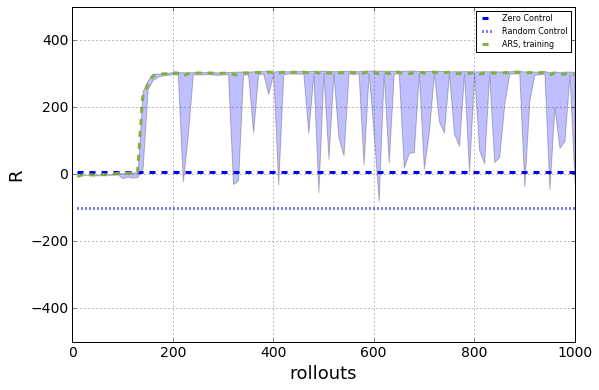

In [14]:
colors = [ '#2D328F', '#F15C19',"#81b13c","#ca49ac"]
          
label_fontsize = 18
tick_fontsize = 14
linewidth = 3
markersize = 5

median_zero = np.median(zero_observed_R)
plt.plot([checkpoints[0],checkpoints[-1]], [median_zero, median_zero], color='#0000FF', linewidth=linewidth,\
             linestyle='--',label='Zero Control')

median_random = np.median(random_observed_R)
plt.plot([checkpoints[0],checkpoints[-1]], [median_random, median_random], color='#0000F3', linewidth=linewidth,\
             linestyle=':', label='Random Control')

plt.plot(training_obs['Iteration'], training_obs['AverageReward'], \
         '--', color=colors[2], linewidth=linewidth, markersize=markersize,label='ARS, training')
plt.fill_between(training_obs['Iteration'], training_obs['MinRewardRollout'], \
                 training_obs['MaxRewardRollout'], alpha=0.25)

plt.axis([0,1000,-500,500])

plt.xlabel('rollouts',fontsize=label_fontsize)
plt.ylabel('R',fontsize=label_fontsize)
plt.legend(fontsize=8, bbox_to_anchor=(1.0, 1.0))
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()

This curve exposes several interesting facts about _both_ ARS and the task:

 - ```ARS``` policies expected performance peaks quite "early" in the training process
 - Variance in the rewards is sometimes very high, resulting in performance worse than the zero input baseline on occasion and close to that of the random policy in one instance.
 - The amplitude in the variation of the rewards does not seem to be decreasing, but rather to be quite uniformly distributed, this _may_ be a sign that 1) the very simple policy architecture we're using isn't capturing sometimes a key feature of the environment or 2) that there is a very low probability event happening which seems to lead to catastrophic failure.

## What Next?

The point of this exercise, besides giving you an example of how to organise your experimental notes to share with us during the few next years :), is to exemplify several key open challenges in present day RL. Also worth noting is that, until the work of Mania et al, it has been very rare to find in the literature experimental work that looks at the variation of rewards or contemplates a significant number of simulations.

My expectation is that the rather poor methods and low degrees of experimental transparency which have been the norm will be cast aside over the next couple years. Meanwhile, the facts are that we should not take at face value most RL papers if we do not see the kind of rigorous (or more rigorous) study above. Plotting average rewards is very misleading, and as exemplified by the last plot, if we are to deploy RL algorithms on mission critical systems we really want to get our foot on the neck of that variance!

In terms of suggestions, I would say that next task would be to see how ARS deals with the simple tasks you were already considering, and how it compares with other methods (DDPG, Salimans' TRPO, more recent Genetic Algorithms). Most of these can be found implemented on libraries like [rl-lib](https://ray.readthedocs.io/en/latest/rllib.html) or [Intel's Reinforcement Learning Coach](https://ai.intel.com/r-l-coach/).